In [28]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
from signal_reader import SignalReader
import keras
import wfdb.processing
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import optuna
import tensorflow as tf

In [2]:
class RecordProcessor:
    def __init__(self):
        self.record_path = None
        self.record = None
        self.annotations = None

    def process(self, signal_reader: SignalReader):
        '''
        Funkcja przygotowuje dane. Wylicza qrsy i odległości rr a następnie dzieli dane na próbki po 60 próbek
        '''
        self.record_path = signal_reader.record_path
        self.record = wfdb.rdrecord(self.record_path)
        signal = signal_reader.read_signal()
        fs = signal_reader.read_fs()
        signal = signal[:, 0]

        # wykrywanie odległości rr
        xqrs = wfdb.processing.XQRS(sig=signal, fs=fs)
        xqrs.detect()
        qrs_inds = xqrs.qrs_inds    # indeksy xqrsów w sygnale
        rr = wfdb.processing.calc_rr(qrs_inds, fs=fs, min_rr=None, max_rr=None, qrs_units='samples', rr_units='seconds')
        
        # tablica referencyjna z wartościami 0 - brak migotania; 1 - migotanie
        self.annotations = wfdb.rdann(self.record_path, 'atr')
        afib_ref = self.read_afib_ref()
        
        # dzielenie na próbki po 60 rr
        sample = self.annotations.sample
        aux_note = self.annotations.aux_note

        bach_size = 60
        data_for_model = []
        label_for_model = []

        for i in range(len(sample)):
            if aux_note[i] == "(AFIB":
                target = sample[i]
                closest_qrs_inds = np.argmin(np.abs(qrs_inds - target)) # szuka indeksu qrs_inds z wartością najbliższą do target
                start_offset = i*77 % bach_size*2 - bach_size # dodajemy offset żeby były w zbiorze próbki z częściowym afib-em
                start = closest_qrs_inds + start_offset
                idx = 0
                # bierzemy 60 próbek rr. Bierzemy w prawo i w lewo od środka dopóki z lewej próbki bez afib a z prawej z afib
                # [ll:lp] [pl:pp] indeksy kolejnych granic okien dla tablic rr i qrs_inds 
                while True:
                    step = bach_size//3
                    ll = start-(idx+1)*step
                    lp = ll+bach_size
                    pl = start+idx*step
                    pp = pl+bach_size
                    left_data = rr[ll:lp]
                    right_data = rr[pl:pp]
                    left_label = np.mean(afib_ref[qrs_inds[ll]:qrs_inds[lp]])
                    right_label = np.mean(afib_ref[qrs_inds[pl]:qrs_inds[pp]])

                    if len(left_data)!=bach_size or len(right_data)!=bach_size:
                        break

                    data_for_model.append(left_data)
                    data_for_model.append(right_data)
                    label_for_model.append(left_label)
                    label_for_model.append(right_label)

                    idx +=1
                    if (i<len(sample)-1 and sample[i+1] <= qrs_inds[pp]) or (i>1 and sample[i-1] >= qrs_inds[ll]) or ll <=60 or pp >= len(rr)-60:
                        break

        data_for_model = np.array(data_for_model)
        label_for_model = np.array(label_for_model)

        # przyjęcie 2s jako górny zakres wartości rr. Normalizacja danych do przedziału [0,1]
        data_for_model = np.where(data_for_model <= 2.0, data_for_model / 2.0, 1.0)

        def save_to_csv(file_path, data, mode='a'):
            # Convert numpy array to pandas DataFrame
            df = pd.DataFrame(data)
            # If the file exists, append without header
            if os.path.exists(file_path) and mode == 'a':
                df.to_csv(file_path, mode=mode, header=False, index=False)
            else:
                # If the file doesn't exist, write with header
                df.to_csv(file_path, mode='w', header=True, index=False)
                
        # Create folder if it doesn't exist
        if not os.path.exists('data'):
            os.makedirs('data')
        data_file = 'data/data_for_model.csv'
        label_file = 'data/label_for_model.csv'
        save_to_csv(data_file, data_for_model)
        save_to_csv(label_file, label_for_model)     
        print(f"save data from {self.record_path} record")   


    def read_afib_ref(self) -> np.ndarray:
        '''
        Funkcja buduje i zwraca tablicę z informacją czy dana próbka należy do przedziału oznaczonego jako migotanie.
        :return: ndarray długości n, gdzie n to liczba probek. 0 - brak migotania; 1 - migotanie; non - brak danych;
        '''
        sample = self.annotations.sample
        aux_note = self.annotations.aux_note
        afib_ref = np.zeros(self.record.sig_len, dtype=np.uint8)
        for i in range(len(sample)):
            if i == len(sample)-1 and aux_note[i] == "(AFIB":
                afib_ref[sample[i]:] = 1.0
            elif aux_note[i] == "(AFIB":
                afib_ref[sample[i]:sample[i+1]] = 1.0
        return afib_ref

In [3]:
db_dir_in_docker = 'D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files'
records = ["04015",
            "04048",
            "04126",
            "04746",
            "04908",
            "04936",
            "05091",
            "05121",
            "05261",
            "06426",
            "06995",
            "07162",
            "07859",
            "07879",
            "07910",
            "08215",
            "08219",
            "08378",
            "08455"]

In [5]:
for record in records:
    signal_reader = SignalReader(os.path.join(db_dir_in_docker, record))

    # procesing data and saving into file
    record_process = RecordProcessor()
    # record_process.process(signal_reader)


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\04015 record
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\04048 record
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\04126 record
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/0

d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\06995 record


d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\07162 record


d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\07859 record


d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\07879 record
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\07910 record
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/05_Studia/Semestr_9_mgr/dnn/BazyDanych/mit-bih-atrial-fibrillation-database-1.0.0/files\08215 record
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
save data from D:/0

LEARN MODEL

In [29]:
def bce_dice_weighted_loss_wrapper(bce_w, dice_w, smooth=10e-6):
    bce_loss = keras.losses.BinaryCrossentropy()
    dice_loss = dice_coef_loss_wrapper(smooth)
    def bce_dice_weighted_loss(y_true, y_pred):
        return bce_w * bce_loss(y_true, y_pred) + dice_w * dice_loss(y_true, y_pred)
    return bce_dice_weighted_loss

def dice_coef_wrapper(smooth=10e-6):
    def dice_coef(y_true, y_pred):
        y_true_f = y_true
        y_pred_f = y_pred
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        return dice
    return dice_coef


def dice_coef_loss_wrapper(smooth=10e-6):
    dice_coef = dice_coef_wrapper(smooth)
    def dice_coef_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)
    return dice_coef_loss

In [ ]:
# Step 1: Load data from CSV files
data_file = 'data/data_for_model.csv'
label_file = 'data/label_for_model.csv'

# Load data and labels
data_for_model = pd.read_csv(data_file, header=None).values
label_for_model = pd.read_csv(label_file, header=None).values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_for_model, label_for_model, test_size=0.3, random_state=42)

# Model Definition
def build_model_for_optuna(input_shape, trial):
    num_filters = trial.suggest_int('num_filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    pool_size = trial.suggest_int('pool_size', 2, 3)
    lstm_units_1 = trial.suggest_int('lstm_units_1', 64, 256)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 64, 256)
    lstm_units_3 = trial.suggest_int('lstm_units_3', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    dense_units = trial.suggest_int('dense_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build the model
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_units_1, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units_2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units_3, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Objective function for Optuna
def objective(trial):
    input_shape = (X_train.shape[1], 1)
    model = build_model_for_optuna(input_shape, trial)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,  # Use a smaller number of epochs for tuning
        batch_size=32,
        verbose=0  # Suppress training output for cleaner logs
    )

    # Get the best validation accuracy from the history
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Create a study and optimize
study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)  # Adjust number of trials as needed

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-01-11 22:09:53,453] A new study created in memory with name: no-name-6f43385d-a33d-4803-8b7d-1c940ecb4ee6
d:\05_Studia\Semestr_9_mgr\dnn\dnn-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-01-11 22:13:16,639] Trial 0 finished with value: 0.8753589987754822 and parameters: {'num_filters': 61, 'kernel_size': 3, 'pool_size': 2, 'lstm_units_1': 132, 'lstm_units_2': 138, 'lstm_units_3': 61, 'dropout_rate': 0.4674278893517528, 'dense_units': 41, 'learning_rate': 0.00021613645064802358}. Best is trial 0 with value: 0.8753589987754822.
[I 2025-01-11 22:15:08,608] Trial 1 finished with value: 0.4646754860877991 and parameters: {'num_filters': 35, 'kernel_size': 5, 'pool_size': 2, 'lstm_units_1': 149, 'lst

Best hyperparameters: {'num_filters': 61, 'kernel_size': 4, 'pool_size': 3, 'lstm_units_1': 104, 'lstm_units_2': 149, 'lstm_units_3': 64, 'dropout_rate': 0.3062535412009404, 'dense_units': 112, 'learning_rate': 0.0011132702866497955}


In [35]:
# Best hyperparameters: {'num_filters': 61, 'kernel_size': 4, 'pool_size': 3, 'lstm_units_1': 104, 'lstm_units_2': 149, 'lstm_units_3': 64, 'dropout_rate': 0.3062535412009404, 'dense_units': 112, 'learning_rate': 0.0011132702866497955}
def build_model(input_shape):
    # Build the model
    model = Sequential()
    model.add(Conv1D(filters=61, kernel_size=4, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LSTM(104, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(149, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(112, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0011132702866497955)
    # model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # compile using functions from baseline
    model.compile(optimizer=optimizer,
                  loss=bce_dice_weighted_loss_wrapper(0.5, 0.5),
                  metrics=[dice_coef_wrapper()])

    return model

model = build_model((X_train.shape[1], 1))

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - dice_coef: 0.6901 - loss: 0.4254 - val_dice_coef: 0.5346 - val_loss: 0.5141
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - dice_coef: 0.8647 - loss: 0.2075 - val_dice_coef: 0.5748 - val_loss: 0.4566
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - dice_coef: 0.8928 - loss: 0.1712 - val_dice_coef: 0.5091 - val_loss: 0.5419
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - dice_coef: 0.8966 - loss: 0.1707 - val_dice_coef: 0.8952 - val_loss: 0.1493
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - dice_coef: 0.9066 - loss: 0.1595 - val_dice_coef: 0.7985 - val_loss: 0.2357
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - dice_coef: 0.9096 - loss: 0.1481 - val_dice_coef: 0.9006 - val_loss: 0.1806
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - dice_coef: 0.9114 - loss: 0.1410 - val_dice_coef: 0.5356 - val_loss: 0.7665
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - dice_coef: 0.9101 - loss: 0

In [41]:
model.save('afib_detection_bilstm_model.keras')

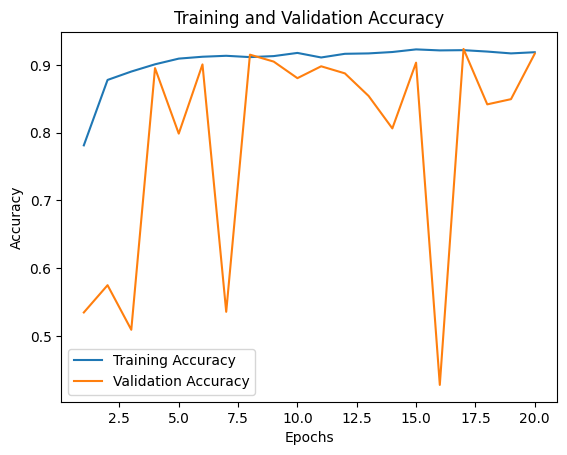

In [40]:
# show results in the plot
# Get the training and validation accuracy from the history object
train_acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

# Get the number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add labels and a title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()